# CytoTRACE runtime comparison

## Library imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from cr2 import running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "cytotrace_kernel" / "benchmarks", exist_ok=True)

## Data loading

In [3]:
data = []
for fname in os.listdir(DATA_DIR / "cytotrace_benchmark" / "out"):
    algo, subset, split = fname.split(".")[0].split("_")
    if algo == "cr":
        df = pd.read_csv(DATA_DIR / "cytotrace_benchmark" / "out" / fname, index_col="sample")
        time_s = df["ct_time"].iloc[0]
        time_p = df["preprocess_time"].iloc[0]
    else:
        df = pd.read_csv(DATA_DIR / "cytotrace_benchmark" / "out" / fname, index_col=0)
        time_s = df.loc["time"][0]
        time_p = 0
    data.append((algo, subset, split, time_s, time_p))

In [4]:
df = pd.DataFrame(data, columns=["algorithm", "subset", "split", "time", "preprocess"])
df["algorithm"] = df["algorithm"].astype("category")
df["subset"] = (df["subset"].astype(int) / 1000).astype(int)
df["time"] += df.pop("preprocess")
df["algorithm"] = df["algorithm"].cat.rename_categories({"cr": "CytoTRACE (CellRank)", "ct": "CytoTRACE (original)"})
df.head()

,algorithm,subset,split,time
0,CytoTRACE (CellRank),30,2,1.546217
1,CytoTRACE (CellRank),20,2,1.139597
2,CytoTRACE (CellRank),20,7,1.095124
3,CytoTRACE (original),10,3,52.885000
4,CytoTRACE (CellRank),1100,3,61.587730


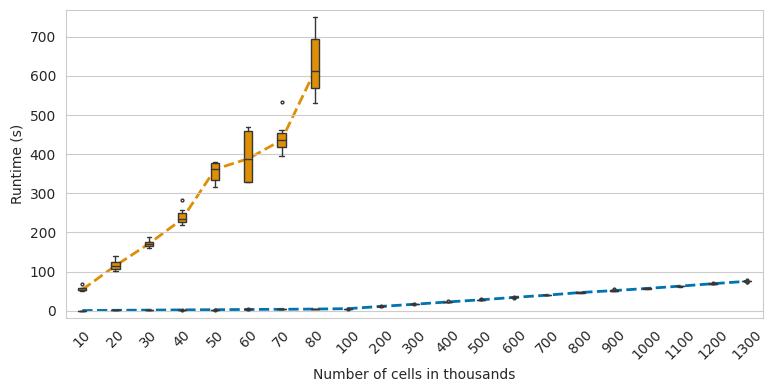

In [10]:
colors = [sns.palettes.color_palette("colorblind")[i] for i in range(len(df["algorithm"].cat.categories))]

if running_in_notebook:
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=(9, 4))
    sns.boxplot(
        data=df,
        x="subset",
        y="time",
        hue="algorithm",
        width=0.25,
        saturation=1,
        dodge=False,
        flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "none", "linestyle": "none"},
        linewidth=1,
        palette="colorblind",
        ax=ax,
    )

    data = df.groupby(["algorithm", "subset"]).median()[["time"]]
    for i, cat in enumerate(df["algorithm"].cat.categories):
        med = data.loc[cat].values.squeeze()
        med = med[med == med]
        ax.plot(np.arange(len(med)), med, c=colors[i], zorder=-1, ls="--", lw=2)

    ax.set_xlabel("Number of cells in thousands")
    ax.set_ylabel("Runtime (s)")
    ax.legend()
    ax.margins(0.025)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")

    ax.set_title("")
    ax.get_legend().remove()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "cytotrace_kernel" / "benchmarks" / "runtime_cr_vs_cytotrace.eps",
            format="eps",
            transparent=True,
            bbox_inches="tight",
        )